# INVERT TOTAL TROPOSPHERIC QGPVP

In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import metpy.calc as mpcalc
from metpy.units import units
import sys

from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim, extract_times, ALL_TIMES, interpz3d, vinterp)

In [2]:
#Define type of tile and desired pressure level
#fullphys_expdom or nolatentheat_expdom
filetype = "fullphys_expdom"                                   #CHANGE
levtitle = "300"

In [3]:
# Open the NetCDF file
ncfile = Dataset("wrfout_"+filetype+".nc", "r")

# Extract the pressure, geopotential height, and wind variables
pressure = getvar(ncfile, "pressure",timeidx=ALL_TIMES)
z = getvar(ncfile, "z", timeidx=ALL_TIMES)
thta = getvar(ncfile, "th",timeidx=ALL_TIMES)
tmpk = getvar(ncfile, "tk",timeidx=ALL_TIMES)
ua = getvar(ncfile, "ua", timeidx=ALL_TIMES, units="kt")
va = getvar(ncfile, "va", timeidx=ALL_TIMES, units="kt")

In [4]:
import pickle
# Getting back the objects:
with open('qgpv_vars_'+levtitle+'_'+filetype+'.pkl', 'rb') as f:
    qgpv, qgpvp, qgpvmean, geop, geopp, geopmean, uamean, vamean, uamean_spec, vamean_spec, SAgeop, SAtmpk, stability = pickle.load(f)

In [5]:
#levtitle = '850'
#import pickle
# Getting back the objects:
#with open('test_qgpv_vars_'+levtitle+'_'+filetype+'.pkl', 'rb') as f:
    #qgpv, qgpvp, qgpvmean, geop, geopp, geopmean, SAgeop, SAtmpk, stability = pickle.load(f)

In [6]:
print(stability)

[8.24488524e-07 9.06927460e-07 1.00291110e-06 1.11564389e-06
 1.24935065e-06 1.40969678e-06 1.60442673e-06 1.84436157e-06
 2.14500783e-06 2.52924984e-06 3.03205360e-06 3.70911766e-06
 4.65380063e-06 6.03288355e-06 8.16986757e-06 2.50568283e-05
 5.86021161e-05 1.15999450e-04]


In [7]:
#Define constants
R = 287.05 #J kg^-1 K^-1
kappa=0.2856219 #Rd / cp
cp = 1004.7 #J kg^-1 K^-1
pref = 1000. #hPa
g = 9.80665 #gravity
omega = 7.292e-5 #Earth's rotation rate (s^-1)
a = 2.e7 / np.pi #Radius of the earth (m)
p0=1.e5
alpha=-1./5.255877
gamma = 0.0065 #lapse rate, (K/m)

In [8]:
#Define pressure level array
pb = 1000. #base pressure
pb_half = 975.
pt = 100. #top pressure
pt_half = 125.
p = np.linspace(pb,pt,19) #make array of size 19 with even spacing from base pressure to top pressure
#p_half = np.linspace(pb_half,pt_half,18)
delp = (p[0] - p[1]) * 100. #Convert to hPa

In [9]:
#Manually define phalf based on length of k and pressure values
phalf = np.zeros((len(p)-1))
for i in range(len(p)-1):
    phalf[i] = (p[i+1] + p[i]) / 2.

In [10]:
#Bounds for inversion
lat1 = 30. #Southern boundary
lat2 = 70. #Northern boundary
lon1 = 150. #Western boundary
lon2 = 250. #Eastern boundary
dlat = lat2 - lat1
dlon = lon2 - lon1
dellatstar = (np.pi/180.) * a
dellonstar = (np.pi/180.) * a
sigma1 = dellonstar / dellatstar
sigma2 = dellonstar / delp

In [11]:
#Get times from dataset
times = extract_times(ncfile, None)
count = np.count_nonzero(times)
#Set t, k, i, j indice lengths
tlen = len(times)
klen = np.shape(qgpvp[:,:,:,:])[1]
ilen = np.shape(qgpvp[:,:,:,:])[2] #This is really the j index (north-south index)
jlen = np.shape(qgpvp[:,:,:,:])[3] #This is really the i index (east-west index)

In [12]:
hght = np.zeros((tlen, klen, ilen, jlen))
levels = [1000,950,900,850,800,750,700,650,600,550,500,450,400,350,300,250,200,150,100]
for t in range(tlen):
    hght[t,:,:,:] = vinterp(ncfile,z[t,:,:,:],'p',levels,extrapolate=True)

In [13]:
lat = getvar(ncfile, "lat")
lon = getvar(ncfile, "lon")

In [14]:
latmax = float(np.max(lat))
latmin = float(np.min(lat))
lonmax = float(np.max(lon))
lonmin = float(np.min(lon))

In [15]:
lat = np.arange(latmin,latmax,((latmax-latmin)/jlen))
lon = np.arange(lonmin,lonmax,((lonmax-lonmin)/ilen))
lenlat = len(lat)
lenlon = len(lon)

In [16]:
#Calculate Coriolis parameter
lenlat = len(lat)
cor = np.zeros((lenlat))
for j in range(lenlat):
    cor[j] = 2. * omega * np.sin(lat[j]*(np.pi / 180.)) # degrees to radians

In [17]:
#Calculate Rossby parameter (beta), variation in Coriolis force with respect to changing latitude
beta = np.zeros((lenlat))
for j in range(lenlat):
    beta[j] = (2. * omega / a) * np.cos(lat[j] * (np.pi / 180.))

In [18]:
#Calculate mean Coriolis Parameter weighted by latitude
fo = 0.
for j in range(lenlat):
    fo = fo + (cor[j] / (dlat+1)) #fo = fo + (cor[j] / (jlen-1))

In [19]:
#Format times to be in standard format
dattimes = []
import pandas as pd
for i in range (0, count):
    dattimes.append(str(pd.Timestamp(times[i])))

## Calculate QGPV coefficients

In [20]:
cosPoint = np.zeros((lenlat))
cosPlus = np.zeros((lenlat)) 
cosPlushalf = np.zeros((lenlat)) 
cosMinus = np.zeros((lenlat)) 
cosMinushalf = np.zeros((lenlat))

for i in range(lenlat):
    cosPoint[i] = np.cos(lat[i] * (np.pi / 180.))
    cosPlus[i] = np.cos((lat[i] + 1.0) * np.pi / 180.)
    cosPlushalf[i] = np.cos((lat[i] + 0.5) * np.pi / 180.)
    cosMinus[i] = np.cos((lat[i] - 1.0) * np.pi / 180.)
    cosMinushalf[i] = np.cos((lat[i] - 0.5) * np.pi / 180.) 

In [21]:
#Coefficients on relative vorticity
A1_rel = np.zeros((lenlat))
A2_rel = np.zeros((lenlat))
A3_rel = np.zeros((lenlat))
A4_rel = np.zeros((lenlat))
A5_rel = np.zeros((lenlat))

for j in range(lenlat):
    A1_rel[j] = 1. / ((cosPoint[j] * dellonstar) ** 2.) # goes on phi(k,i-1,j)
    A2_rel[j] = cosMinushalf[j]/(cosPoint[j]*dellatstar ** 2.) # goes on phi(k,i,j-1)
    A3_rel[j] = (-2. / (cosPoint[j] * dellonstar) ** 2.) - (cosPlushalf[j] / (cosPoint[j] * dellatstar ** 2.)) - (cosMinushalf[j] / (cosPoint[j] * dellatstar ** 2.)) #goes on phi(k,i,j)
    A4_rel[j] = 1. / ((cosPoint[j] * dellonstar) ** 2.) # goes on phi(k,i+1,j) 
    A5_rel[j] = cosPlushalf[j] / (cosPoint[j] * dellatstar ** 2.) # goes on phi(k,i,j+1)
    
    

In [22]:
#Coefficients for QGPV
A1_qgpv = np.zeros((lenlat)) # goes on phi(t,j,i-1,k)
A2_qgpv = np.zeros((lenlat))
A2i_qgpv = np.zeros((lenlat)) # goes on phi(t,j-1,i,k)
A3_qgpv = np.zeros((len(p), lenlat)) # goes on phi(t,j,i,k) has parts in vert, meridional
A3i_qgpv = np.zeros((len(p), lenlat)) # goes on phi(t,j,i,k) has parts in vert, meridional
A4_qgpv = np.zeros((lenlat)) # goes on phi(t,j+1,i,k)
A4i_qgpv = np.zeros((lenlat)) # goes on phi(t,j+1,i,k)
A5_qgpv= np.zeros((lenlat)) # goes on phi(t,j,i+1,k) 
A6_qgpv = np.zeros((len(p))) # goes on phi(t,j,i,k-1) 
A7_qgpv = np.zeros((len(p))) # goes on phi(t,j,i,k+1) 
A8_qgpv = dellonstar ** 2. # goes on q-f 

    
for k in range(2,len(p)-1):
    
    A6_qgpv[k] = (fo * sigma2 ** 2.) / stability[k-1] 
    A7_qgpv[k] = (fo * sigma2 ** 2.) / stability[k]
                   
    for j in range(lenlat):
        A1_qgpv[j] = 1. / (fo * cosPoint[j] ** 2.) 
        A2_qgpv[j] = (sigma1 ** 2.) * cosMinus[j] / (fo * cosPoint[j])
        A2i_qgpv[j] = (sigma1 ** 2.) * cosMinushalf[j] / (fo * cosPoint[j]) 
        A4_qgpv[j] = ((sigma1 ** 2.) * cosPlus[j] / (fo * cosPoint[j]))
        A4i_qgpv[j] = ((sigma1 ** 2.) * cosPlushalf[j] / (fo * cosPoint[j])) 
        A5_qgpv[j] = 1. / (fo * cosPoint[j] ** 2.)
                   
        A3_qgpv[k,j] = -1. * ((2. / (fo * cosPoint[j] ** 2.)) + ((sigma1 ** 2.) / fo) * ((cosPlus[j] / cosPoint[j]) + (cosMinus[j] / cosPoint[j])) + ((4. * fo * sigma2 ** 2.) * ((1. / stability[k-1]) + (1. / stability[k])))) 
        A3i_qgpv[k,j] = (-2. / (fo * cosPoint[j] ** 2.)) + (((sigma1 ** 2.) / fo) * ((-cosPlushalf[j] / cosPoint[j]) - (cosMinushalf[j] / cosPoint[j]))) + ((fo * sigma2 ** 2.) * ((-1. / stability[k-1]) - (1. / stability[k]))) 


In [23]:
#Define arrays to store calculations
rel_vor = np.zeros((tlen, klen, ilen, jlen))
strvor = np.zeros((tlen, klen, ilen, jlen))

In [24]:
#Reshape SAgeop for calculation
SAgeop1 = np.zeros((tlen, klen, ilen, jlen))
for t in range(tlen):
    for k in range(klen):
        SAgeop1[t,k,:,:] = SAgeop[k]

In [25]:
#Reshape SAtmpk for calculation
SAtmpk1 = np.zeros((tlen, klen, ilen, jlen))
for t in range(tlen):
    for k in range(klen):
        SAtmpk1[t,k,:,:] = SAtmpk[k]

In [26]:
#Define arrays for storing calculations
tmpkmean = np.zeros((klen, ilen, jlen)) #mean temp in Kelvin
tmpkmean_SArem = np.zeros((klen, ilen, jlen))
tmpk_SArem = np.zeros((tlen, klen, ilen, jlen))

In [27]:
#Subtract standard atmosphere temperature (from QGPV derivation, QG thermo equation)
for t in range(tlen):
    for k in range(klen):
        tmpk_SArem[t,k,:,:] = tmpk[t,k,:,:] - SAtmpk1[t,k,:,:]

In [ ]:
#Calculate geopotential, temp (K) anomalies
#MEAN TMPK ANOMALIES TAKE AWHILE TO RUN
#for k in range(klen):
    #for i in range(ilen):
        #for j in range(jlen):
            #tmpkmean[k,i,j]=np.squeeze(np.mean(tmpk[0:-1,k,i,j])) 
            #tmpkmean_SArem[k,i,j]=np.squeeze(np.mean(tmpk_SArem[0:-1,k,i,j])) 


In [ ]:
#Calculate relative vorticity
for t in range(tlen):
    for k in range(1, klen-1):
        for i in range(1, ilen-1):
            for j in range(1, jlen-1): 
                rel_vor[t,k,i,j] = ((A1_rel[j] * geop[t,k,i-1,j]) + (A2_rel[j] * geop[t,k,i,j-1]) + (A3_rel[j] * geop[t,k,i,j]) + (A4_rel[j] * geop[t,k,i+1,j]) + (A5_rel[j] * geop[t,k,i,j+1])) / fo
                        

In [ ]:
# calculate stretching vorticity  
str_vortot = np.zeros((tlen, klen, ilen, jlen))  
first_der = np.zeros((tlen, klen, ilen, jlen))

for t in range(tlen):
    for k in range(klen-1):
        first_der[t,k,:,:] = (1. / stability[k]) * ((geop[t,k,:,:] - geop[t,k+1,:,:]) / (delp))
            
            

In [ ]:
#More stretching vorticity calculations
for t in range(tlen):
    for k in range(1,klen-1):
        str_vortot[t,k,:,:]= fo * (first_der[t,k-1,:,:] - first_der[t,k,:,:]) / (delp) 


## INVERT THE PERTURBATION UPPER-LEVEL QGPV TO GET THE ASSOCIATED GEOPOTENTIAL

### iterative successive overrelaxation technique is used to attain solutions

### alpha is a parameter to expedite inversion, while the tolerance is set as the change in the solution from the previous to current iteration, summed over all gridpoints. lower tolerance == lower precision but after a certain point you are not gaining any information by enhancing the tolerance

In [28]:
d2r=np.pi/180.
a = 6371.e3
dlon = a*0.5*d2r
dlat = a*0.5*d2r
dp = 50.e2
gamma=.0065
omega = 7.292E-5
f0 = 0.5*(2*omega*(np.sin(d2r*lat[0])+np.sin(d2r*lat[-1])))

In [29]:
#Laplacian coefficient
d2r=np.pi / 180.
a = 6371.e3
dlon = a * 0.5 * d2r
dlat = a * 0.5 * d2r
dp = 50.e2
omega = 7.292E-5
lat_rad=d2r * lat

sigma = (dlon / dlat)
sigma_squared = sigma * sigma

A1 = np.zeros([lenlat])
A2 = np.zeros([lenlat])
A3 = np.zeros([klen,lenlat])
A4 = np.zeros([lenlat])
A5 = np.zeros([lenlat])
A6 = np.zeros([klen])
A7 = np.zeros([klen])     

In [30]:
for k in np.arange(1,klen-1):
    A6[k]=f0/(stability[k-1]*dp**2.)
    A7[k]=f0/(stability[k]*dp**2.)
for k in np.arange(0,klen-1):
    for j in np.arange(1,jlen-1):
        latPlushalf = (lat_rad[j] + lat_rad[j+1]) / 2.
        latMinushalf = (lat_rad[j] + lat_rad[j-1]) / 2.
        
        A1[j]=np.cos(latMinushalf)/(np.cos(lat_rad[j])*(dlat)**2.)
        A2[j]=1./( dlon * np.cos(lat_rad[j]) )**2.
        A3[k,j]=-(A6[k]+A7[k])-(2./(dlon*np.cos(lat_rad[j]))**2. + (np.cos(latMinushalf)+np.cos(latPlushalf))/(np.cos(lat_rad[j])*(dlat)**2.))
        A4[j]=A2[j]
        A5[j]=np.cos(latPlushalf)/(np.cos(lat_rad[j])*(dlat)**2.) 

In [31]:
A1 = dlon * dlon * A1        
A2 = dlon * dlon * A2        
A3 = dlon * dlon * A3        
A4 = dlon * dlon * A4        
A5 = dlon * dlon * A5        
A6 = dlon * dlon * A6        
A7 = dlon * dlon * A7  

In [32]:
#geopper = np.zeros((tlen, klen, ilen, jlen))

#for t in range(tlen):
    #for i in range(ilen):
        #for j in range(jlen):
              #geopper[t,0,i,j] = geopper[t,1,i,j] - ((R*delp)/(975.0*100.))*qgpvp[t,1,i,j]
              #geopper[t,klen-1,i,j] = geopper[t,klen-1,i,j] - ((R*delp)/(975.0*100.))*qgpvp[t,klen-1,i,j]


In [33]:
#set the sides of the domain to the observed geopotential anomaly for
#the levels at which the QGPV anomaly is retained
#for t in range(tlen):
    #for k in range(klen):
        #for i in range(ilen):
            #geopper[t,k,i,0] = geop[t,k,i,0] - geopmean[k,i,0]
            #geopper[t,k,i,jlen-1] = geop[t,k,i,jlen-1] - geopmean[k,i,jlen-1]
        #for j in range(jlen): 
            #geopper[t,k,0,j] = geop[t,k,0,j] - geopmean[k,0,j]
            #geopper[t,k,ilen-1,j] = geop[t,k,ilen-1,j] - geopmean[k,ilen-1,j]
            
            

In [34]:
#print(geopper[0,1,1:100,1:100])

In [35]:
geopper = np.zeros((tlen, klen, ilen, jlen))
res_list = []
errvar = 10.e-2
for t in np.arange(tlen):
    print("Working on time: ", dattimes[t])
    for iter in range(150):
        error = 0
        for k in np.arange(1,4):
            for i in np.arange(1,ilen-2):
                for j in np.arange(1,jlen-2):
                    res = A1[j]*geopper[t,k,i,j-1] + A2[j]*geopper[t,k,i-1,j] + A3[k,j]*geopper[t,k,i,j] + A4[j]*geopper[t,k,i+1,j] + A5[j]*geopper[t,k,i,j+1] + A6[k]*geopper[t,k-1,i,j] + A7[k]*geopper[t,k+1,i,j] - qgpvp[t,k,i,j]*dlon*dlon
                    geopper[t,k,i,j] = geopper[t,k,i,j] - 1.9*res/A3[k,j]
                    error = error + abs(res)
                    
            if(k==1): 
                geopper[t,0,:,:] = geopper[t,1,:,:]
            if(k==klen-2): 
                geopper[t,-1,:,:] = geopper[t,-2,:,:]
                        
            
            unit_error = error/((klen-2)*(ilen-2)*(jlen-2))
            res_list.append(unit_error)
            
        if(unit_error < errvar):      # error threshold, average absolute error must be less than specified
            print('amount of error:')
            print('got here: ',error/((ilen-2) * (jlen-2) * (klen-2)), iter)
            break
        #print(geopper[:,27,67])
        #print(iter)
# number of iterations until convergence
print('hmm . . . number of iterations = ', iter)  

Working on time:  2019-11-25 12:00:00
amount of error:
got here:  0.07201207667175595 25
Working on time:  2019-11-25 15:00:00
amount of error:
got here:  0.06685820331426488 25
Working on time:  2019-11-25 18:00:00
amount of error:
got here:  0.06322150445665417 25
Working on time:  2019-11-25 21:00:00
amount of error:
got here:  0.0592804781640263 25
Working on time:  2019-11-26 00:00:00
amount of error:
got here:  0.05731814937003929 25
Working on time:  2019-11-26 03:00:00
amount of error:
got here:  0.05427566982826093 25
Working on time:  2019-11-26 06:00:00
amount of error:
got here:  0.0965556993403478 24
Working on time:  2019-11-26 09:00:00
amount of error:
got here:  0.09313850814967574 24
Working on time:  2019-11-26 12:00:00
amount of error:
got here:  0.08933772138640109 24
Working on time:  2019-11-26 15:00:00
amount of error:
got here:  0.08778722253680528 24
Working on time:  2019-11-26 18:00:00
amount of error:
got here:  0.08507140418761878 24
Working on time:  2019-

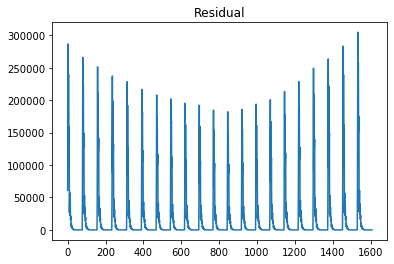

In [36]:
#Plot residual error
plt.plot(res_list)
plt.title("Residual")
plt.show()

In [37]:
levtitle = "850"

In [38]:
#geopp is observed geopotential anomalies, geopper is calculated geopotential anomalies from inversion
geopanom_obs = geopp
hghtanom_obs = geopp / g

#geopper is from the inversion
#difference between obs and inversion
geop_diff = geopanom_obs - geopper 
hght_diff = geop_diff / g 

#geop_anom_inv is from inversion
geop_anom_inv = geopper / g

In [39]:
#Save data to file for use in other notebooks
import pickle
with open('inv_qgpv_tot_trop_'+levtitle+'_'+filetype+'.pkl', 'wb') as f:
    pickle.dump([geopper, geopp, geop_anom_inv, geop_diff, hght_diff, geopanom_obs], f)

In [ ]:
#PLOTTING FOR 300 hPa GEOPOTENTIAL ANOMALY
for i in range (tlen):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    lev = 14 #--> 300 hPa
    levtitle = '300' #CHANGE

    tmp1 = geop_anom_inv[i,lev,:,:]
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-100, vmax=100,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()


    ax.set_title('WRF '+levtitle+'-hPa Inverted Geopotential Height Anomaly (m^2/s^2) \n Valid Time: {}'.format(dattimes[i]))
    #($\frac{m}{s^{-2}}$)

    plt.savefig('plots/inv_tot_trop/'+filetype+'/invheightanom/invheightanom_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [ ]:
#PLOTTING FOR 500 hPa GEOPOTENTIAL ANOMALY
for i in range (tlen):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    lev = 10 #--> 300 hPa
    levtitle = '500' #CHANGE

    tmp1 = geop_anom_inv[i,lev,:,:]
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-100, vmax=100,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()


    ax.set_title('WRF '+levtitle+'-hPa Inverted Geopotential Height Anomaly (m^2/s^2) \n Valid Time: {}'.format(dattimes[i]))
    #($\frac{m}{s^{-2}}$)

    plt.savefig('plots/inv_tot_trop/'+filetype+'/invheightanom/invheightanom_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [40]:
#PLOTTING FOR 850 hPa GEOPOTENTIAL ANOMALY
for i in range (tlen):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    lev = 3 #--> 300 hPa
    levtitle = '850' #CHANGE

    tmp1 = geop_anom_inv[i,lev,:,:]
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-100, vmax=100,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()


    ax.set_title('WRF '+levtitle+'-hPa Inverted Geopotential Height Anomaly (m^2/s^2) \n Valid Time: {}'.format(dattimes[i]))
    #($\frac{m}{s^{-2}}$)

    plt.savefig('plots/inv_tot_trop/'+filetype+'/invheightanom/invheightanom_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

Working on time:  2019-11-25 12:00:00
Working on time:  2019-11-25 15:00:00
Working on time:  2019-11-25 18:00:00
Working on time:  2019-11-25 21:00:00
Working on time:  2019-11-26 00:00:00
Working on time:  2019-11-26 03:00:00
Working on time:  2019-11-26 06:00:00
Working on time:  2019-11-26 09:00:00
Working on time:  2019-11-26 12:00:00
Working on time:  2019-11-26 15:00:00
Working on time:  2019-11-26 18:00:00
Working on time:  2019-11-26 21:00:00
Working on time:  2019-11-27 00:00:00
Working on time:  2019-11-27 03:00:00
Working on time:  2019-11-27 06:00:00
Working on time:  2019-11-27 09:00:00
Working on time:  2019-11-27 12:00:00
Working on time:  2019-11-27 15:00:00
Working on time:  2019-11-27 18:00:00
Working on time:  2019-11-27 21:00:00
Working on time:  2019-11-28 00:00:00


In [ ]:
#PLOTTING FOR 300 hPa HEIGHT DIFFERENCE
for i in range (tlen):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    lev = 14 #--> 300 hPa
    levtitle = '300' #CHANGE

    tmp1 = hght_diff[i,lev,:,:]
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-100, vmax=100,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()


    ax.set_title('WRF '+levtitle+'-hPa Height Difference (m), Observation -  Inversion \n Valid Time: {}'.format(dattimes[i]))
    
    plt.savefig('plots/inv_tot_trop/'+filetype+'/heightdiff/heightdiff_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [ ]:
#PLOTTING FOR 500 hPa HEIGHT DIFFERENCE
for i in range (tlen):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    lev = 10 #--> 500 hPa
    levtitle = '500' #CHANGE

    tmp1 = hght_diff[i,lev,:,:]
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-100, vmax=100,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()


    ax.set_title('WRF '+levtitle+'-hPa Height Difference (m), Observation -  Inversion \n Valid Time: {}'.format(dattimes[i]))
    
    plt.savefig('plots/inv_tot_trop/'+filetype+'/heightdiff/heightdiff_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [41]:
#PLOTTING FOR 850 hPa HEIGHT DIFFERENCE
for i in range (tlen):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    lev = 3 #--> 850 hPa
    levtitle = '850' #CHANGE

    tmp1 = hght_diff[i,lev,:,:]
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-100, vmax=100,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()


    ax.set_title('WRF '+levtitle+'-hPa Height Difference (m), Observation -  Inversion \n Valid Time: {}'.format(dattimes[i]))
    
    plt.savefig('plots/inv_tot_trop/'+filetype+'/heightdiff/heightdiff_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

Working on time:  2019-11-25 12:00:00
Working on time:  2019-11-25 15:00:00
Working on time:  2019-11-25 18:00:00
Working on time:  2019-11-25 21:00:00
Working on time:  2019-11-26 00:00:00
Working on time:  2019-11-26 03:00:00
Working on time:  2019-11-26 06:00:00
Working on time:  2019-11-26 09:00:00
Working on time:  2019-11-26 12:00:00
Working on time:  2019-11-26 15:00:00
Working on time:  2019-11-26 18:00:00
Working on time:  2019-11-26 21:00:00
Working on time:  2019-11-27 00:00:00
Working on time:  2019-11-27 03:00:00
Working on time:  2019-11-27 06:00:00
Working on time:  2019-11-27 09:00:00
Working on time:  2019-11-27 12:00:00
Working on time:  2019-11-27 15:00:00
Working on time:  2019-11-27 18:00:00
Working on time:  2019-11-27 21:00:00
Working on time:  2019-11-28 00:00:00


In [ ]:
#PLOTTING FOR 300 hPa OBS HEIGHT ANOMALY
for i in range (0,count):
    print("Working on time: ", dattimes[i])
    
    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    #lev = 3 --> 850 hPa
    #lev = 14 --> 300 hPa
    levtitle = '300' #CHANGE
    lev = 14 #CHANGE


    tmp1 = np.squeeze(hghtanom_obs[i,lev,:,:])
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-250., vmax=250.,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()

    ax.set_title('WRF '+levtitle+'-hPa Observed Height Anomaly (m) \n Valid Time: {}'.format(dattimes[i]))
    
    plt.savefig('plots/inv_tot_trop/'+filetype+'/obsheightanom/obsheightanom_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [ ]:
#PLOTTING FOR 500 hPa OBS HEIGHT ANOMALY
for i in range (0,count):
    print("Working on time: ", dattimes[i])

    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    #lev = 3 --> 850 hPa
    #lev = 14 --> 300 hPa
    levtitle = '500' #CHANGE
    lev = 10 #CHANGE


    tmp1 = np.squeeze(hghtanom_obs[i,lev,:,:])
    tmp1[tmp1 > 5000.] = np.nan
    tmp1[tmp1 < -5000.] = np.nan
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-250., vmax=250.,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()

    ax.set_title('WRF '+levtitle+'-hPa Observed Height Anomaly (m) \n Valid Time: {}'.format(dattimes[i]))
    
    plt.savefig('plots/inv_tot_trop/'+filetype+'/obsheightanom/obsheightanom_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [ ]:
#PLOTTING FOR 850 hPa OBS HEIGHT ANOMALY
for i in range (0,count):
    print("Working on time: ", dattimes[i])

    # Get the map projection information
    cart_proj = get_cartopy(wrfin=ncfile)
    
    lats, lons = latlon_coords(z)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    # Create the figure
    fig = plt.figure(figsize=(12,9))
    ax = plt.axes(projection=cart_proj)
    # Download and add the states and coastlines
    states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
    ax.add_feature(states, linewidth=0.5, edgecolor="black")
    ax.coastlines('50m', linewidth=0.8)

    #Desired pressure (levtitle) and corresponding k value
    #lev = 3 --> 850 hPa
    #lev = 14 --> 300 hPa
    levtitle = '850' #CHANGE
    lev = 3 #CHANGE


    tmp1 = np.squeeze(hghtanom_obs[i,lev,:,:])
    tmp1[tmp1 > 5000.] = np.nan
    tmp1[tmp1 < -5000.] = np.nan
    #qgcs = plt.contour(to_np(lons), to_np(lats), to_np(tmp1), colors='red',
                 #linestyles='dashed', transform=crs.PlateCarree())
    #qgcs = plt.contourf(to_np(lons), to_np(lats), to_np(tmp1), cmap='summer', transform=crs.PlateCarree())
    #plt.clabel(qgcs, fmt ='%.1f',inline=True)

    qgcs = plt.pcolormesh(to_np(lons), to_np(lats), to_np(tmp1),
                                cmap='bwr', vmin=-250., vmax=250.,
                                transform=crs.PlateCarree())
    plt.colorbar(qgcs, ax=ax, orientation="horizontal", pad=.05)

    # Set the map bounds
    ax.set_xlim(cartopy_xlim(z))
    ax.set_ylim(cartopy_ylim(z))

    ax.gridlines()

    ax.set_title('WRF '+levtitle+'-hPa Observed Height Anomaly (m) \n Valid Time: {}'.format(dattimes[i]))
    
    plt.savefig('plots/inv_tot_trop/'+filetype+'/obsheightanom/obsheightanom_'+levtitle+'_'+filetype+'_{}.pdf'.format(dattimes[i]))
    plt.close()

In [ ]:
#Melissa's inversion calculation

#import time
#start = time.time()

#for t in range(tlen):
    #print("Working on time: ", dattimes[t])
    #for m in range(10): #Fast inversion: m = 10, Slow inversion: m = 5000
        #check = 0
        #for k in range(1, klen-1):
            #print("I am here: ", k)
            #for i in range(1, ilen-1):
                #for j in range(1, jlen-1):
                    #A3i_qgpv[A3i_qgpv==0] = np.nan
                    #geoppertemp = ((qgpvp[t,k,i,j])*A8_qgpv-A1_qgpv[j]*geopper[t,k,i-1,j]-A2i_qgpv[j]*geopper[t,k,i,j-1]-A4i_qgpv[j]*geopper[t,k,i,j+1]-A5_qgpv[j]*geopper[t,k,i+1,j]-A6_qgpv[k]*geopper[t,k-1,i,j]-A7_qgpv[k]*geopper[t,k+1,i,j])/A3i_qgpv[k,j]
                    #res = geopper[t,k,:,:] - geoppertemp
                    #geopper[t,k,:,:] = geopper[t,k,:,:] - (alpha * res)
                    #error = error + abs(res)
                    #print(error)
                    
                    # incorporate upper/lower level boundary theta into solution 
                    #if (k == 1):
                        #geopper[t,0,:,:] = geopper[t,1,:,:] - ((Rconst*delp)/(phalf[0]*100.))*qgpvp[t,0,:,:]                  
                    #elif (k == 30):
                        #geopper[t,31,:,:] = geopper[t,30,:,:] + ((Rconst*delp)/(phalf[-1]*100.))*qgpvp[t,31,:,:]
    #if (check < tol):
        #print("Woohoo! Convergence!")
        #break
        
    #elif (m < 5000):
        #print("m= ", m)
        #print("check= ", check)
        
    #elif (m == 5000):
        #print("No convergence reached...try again")
        #break
        
    #print("I am here: ", m)

#print ("Clock time to run= ",time.time()- start," seconds")                 
                    